<a href="https://colab.research.google.com/github/piyushdutt28/UniformClassifier/blob/main/Uniform_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement:
Identify Soldier based on the Uniform (CRPM,BSF,JAmmu &amp; Kashmir Police) take
random image of soldier to application and which force they Belongs to using Deep
Learning Concept.

Edge Scenario is Bonus

Importing necessary libraries for setting up the database, training the model and visualising the performance.

In [ ]:
import cv2
import re
from PIL import Image
import numpy as np
import glob
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import os
import matplotlib.pyplot as plt
from torch import optim
from sklearn.metrics import classification_report

Initializes the VGG-16 model architecture with pre-trained weights from the ImageNet dataset.

In [ ]:
model_ft = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 294MB/s]


Taking first 5 layers of VGG16.

Next, an adaptive average pooling layer is added to downsample the output of the convolutional layers to a fixed size, which helps to reduce the number of parameters in the model and improve generalization.

After that, a convolutional layer with smaller output channels is added to the model, followed by a dropout layer to reduce overfitting. Dropout randomly sets a certain fraction of the activations in the previous layer to zero during training, which helps to prevent the model from memorizing the training data too well.

Finally, another convolutional layer is added for transfer learning. These layers will be trained on our specific task, while the earlier layers will remain frozen and continue to use the pre-trained weights.


In [ ]:
model=[x for x in model_ft.children()][0][0:6]
model=nn.Sequential(*[model,nn.AdaptiveAvgPool2d((16, 16)),
                      nn.Conv2d(128,32,kernel_size=(3, 3),stride=(2,2)),
                      nn.Dropout(p=0.1),
                     nn.Conv2d(32,8,kernel_size=(3, 3))])

Initialising custom classifier with a fully connected layer for the 3 classes. 

Defining forward method in the class.

In [ ]:
class classifier(nn.Module):
    def __init__(self,model):
        super(classifier, self).__init__()
        self.model=model
        self.dense=nn.Linear(200,3)
    def forward(self,x):
        x=model(x)
        return self.dense(x.view(-1,200))
    


#Data Augmentation

Using torchvision transforms to augment the data, for efficient learning of model.

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, img_paths,aug=True,cv=False):
        self.cv=cv
        self.aug=aug
        self.img_paths = list(glob.glob(img_paths+"/**/*.jp*",recursive=True))
        self.label_enc = {"bsf":0,"crpf":1,"j&k":2}
        self.data_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=.1, hue=.1),
            transforms.RandomAutocontrast(p=0.2),
#             transforms.Pad(padding=3,),
            transforms.ToTensor(),
        ])
        self.no_transforms=transforms.ToTensor()
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img=Image.open(self.img_paths[idx])
        label= os.path.dirname(self.img_paths[idx]).split("/")[-1]
        label=self.label_enc[label]
        if self.cv:
            img=cv2.imread(self.img_paths[idx])/255
            img=np.array(img[::,::,::-1].copy(),np.float32)
            if img.shape[0]<img.shape[1]:
                ratio=img.shape[0]
            
            
        if self.aug:
            img=self.data_transforms(img)
        else:
            img=self.no_transforms(img)
#         label=torch.zeros(1,)
        return img,label

Importing my personal drive in collab. I will send the training data seperately. So the image directory can be modified later.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Using Data Augmentation function of the training Dataset. 
Then using dataloader to load the data ready for training.

*Very limited dataset (around 100 images for each class, including test and train)*

['/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/904098-20367-tlhrphkxuk-1484655342.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/156224-iuwovjwzel-1615799310.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/2f8209b176s36.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/405539-border-security-force-bsf.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/5470e35748155bf30e2dbeba51c36fa7.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/129266-zbbgxpxkzg-1646553615.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/2022_4$largeimg_1957443104.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/64339c8b-ca26-4f03-ac46-557cbfb0589320220524013421_202205.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/10cc8b3d-d1f8-4755-b7c4-a1113fbf2862_1655795526644.jpg',
 '/content/drive/MyDrive/Collab/Bulk Image Downloader/test/bsf/1005590

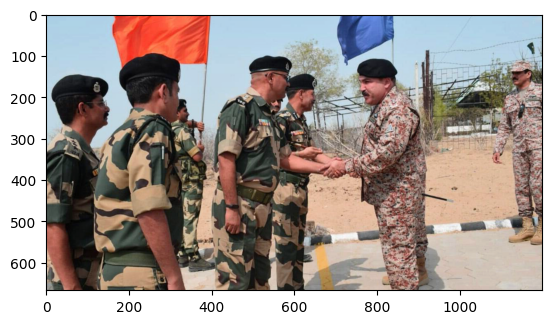

In [ ]:
i=CustomImageDataset('/content/drive/MyDrive/Collab/Bulk Image Downloader/train')
j=CustomImageDataset('/content/drive/MyDrive/Collab/Bulk Image Downloader/test',aug=False, cv=True)
training_generator = torch.utils.data.DataLoader(i,shuffle=True)
test_generator= torch.utils.data.DataLoader(j)
# for x in training_generator:
for x in training_generator:
    # print(x)
    pass
#     break
plt.imshow(torch.permute(x[0][0],(1,2,0))),x[1]
j.img_paths

 - Initialising model as "m"

 - Using Stochastic Gradient Descent for optimising the weights (Generally used in Classification Problem)

 - Using Cross Entropy loss function to evaluate the performance of model while training.

**Detailed Model Architecture can be found below.**

In [ ]:
m=classifier(model)
optimizer = optim.SGD([{"params":m.model[2:].parameters()},{"params":m.dense.parameters()}], lr=0.00003, momentum=0.9)
loss = nn.CrossEntropyLoss()
m=m.cuda()
m.train()

classifier(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): AdaptiveAvgPool2d(output_size=(16, 16))
    (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(2, 2))
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1))
  )
  (dense): Linear(in_features=200, out_features=3, bias=True)
)

#Training

Using the Train and Test Generator to train the model for 50 epochs.

As we can see below that the accuracy oscillates around 30-70 % on the limited test dataset during training.

In [ ]:
m=m.cuda()
m.train()
acc_t=0

for epoch in range(50):
    optimizer.zero_grad()
    i=0
    tt,tti=[],[]
    for x,y in training_generator:
       
        x=x.cuda()
        y=y.cuda()
        optimizer.zero_grad()
        out=m(x)
        tt.append(torch.argmax(out.softmax(dim=1),dim=1).clone().detach().cpu().numpy())
        tti.append(y.cpu().numpy())
        l=loss(out,y)
        l.backward()
        optimizer.step()
        i+=1
        
        
    if 1:
        print(l)
        with torch.no_grad():
            m.eval()
            res=[]
            actual=[]
            for x,y in test_generator:
#                 x=x.permute((0,3,1,2,))
                x=x.cuda()

                t=torch.argmax(m(x).softmax(dim=1),dim=1).clone().detach().cpu().numpy()
                res.append(t)
                actual.append(y.numpy())
#             print(actual,"########",res)
            print(classification_report(actual,res)) 
            acc=float(re.findall('([0-9].[0-9]+)',classification_report(actual,res).split("\n")[-4])[0])
#             print(classification_report(tti,tt)) 
            print("#",acc)
            if acc >acc_t:
                torch.save(m.state_dict(), 'classifier.pth')
                acc_t=acc

            print("#")
        m.train()
    
#             torch.save(m)
                


tensor(0.9611, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           0       0.38      0.21      0.27        14
           1       0.29      0.42      0.34        12
           2       0.30      0.33      0.32         9

    accuracy                           0.31        35
   macro avg       0.32      0.32      0.31        35
weighted avg       0.33      0.31      0.31        35

# 0.31
#
tensor(0.9623, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-score   support

           0       0.38      0.21      0.27        14
           1       0.31      0.42      0.36        12
           2       0.27      0.33      0.30         9

    accuracy                           0.31        35
   macro avg       0.32      0.32      0.31        35
weighted avg       0.33      0.31      0.31        35

# 0.31
#
tensor(1.3574, device='cuda:0', grad_fn=<NllLossBackward0>)
              precision    recall  f1-sc

#Visualising

The trained model can be evaluated by seeing the images and the tensor class.

*I can make a classifier class to load and evaluate saved model in classifier.pth. But due to lack of time I couldn't. *

tensor([0]) tensor([0])


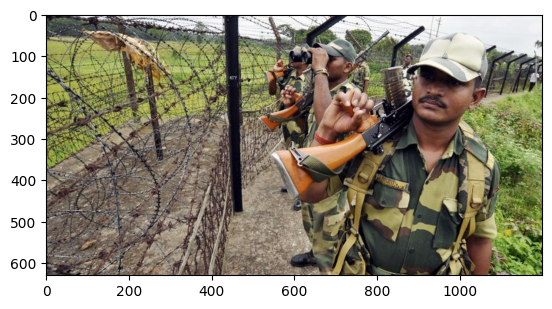

#############
tensor([0]) tensor([0])


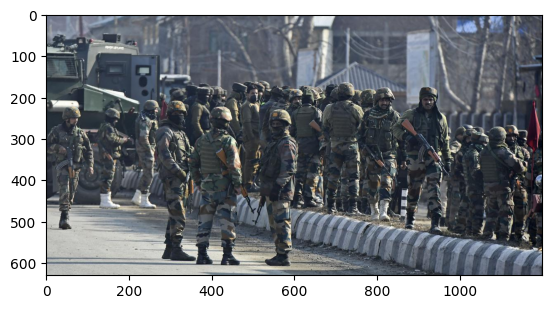

#############
tensor([0]) tensor([0])


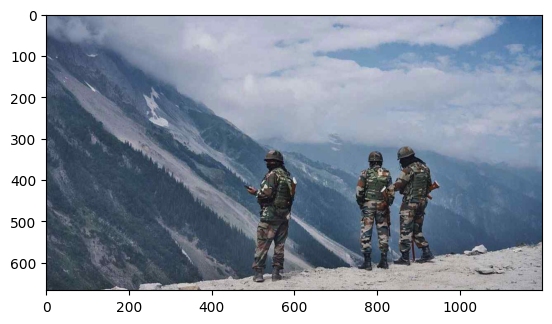

#############
tensor([1]) tensor([0])


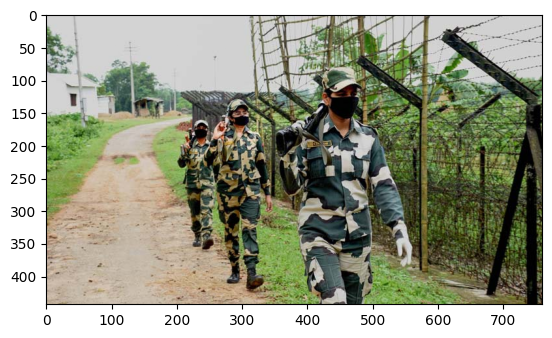

#############
tensor([1]) tensor([0])


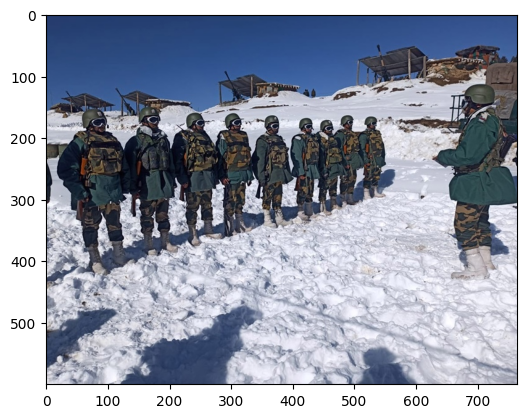

#############
tensor([0]) tensor([0])


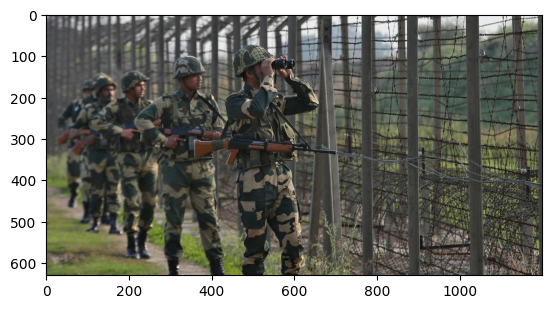

#############


In [ ]:
m=m.to('cpu')
m.eval()
m=m.cpu()
with torch.no_grad():
    for x in test_generator:
        print(torch.argmax(m(x[0]).softmax(dim=1),dim=1),x[1])
        plt.imshow(torch.permute(x[0][0],(1,2,0))),x[1]
        plt.show()
        print("#############")